In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline

In [2]:
def rk4(f, y0, h, start, stop):
    N = int(np.ceil((stop - start)/h))
    t = np.zeros(N+1)
    y = np.zeros((N+1,4))
    y[0] = y0
    t[0] = start
    for i in range(N):
        k1 = h*f(y[i])
        k2 = h*f(y[i] + k1/2)
        k3 = h*f(y[i] + k2/2)
        k4 = h*f(y[i] + k3)
        y[i+1] = y[i] + (k1 + 2*k2 + 2*k3 + k4)/6
        t[i+1] = t[i] + h
    return (t, y)

In [3]:
m = 1
l = 1
g = 9.81
def f(y):
    theta1 = y[0]
    theta2 = y[1]
    p1 = y[2]
    p2 = y[3]
    f1 = 6/(m*l**2)*(2*p1-3*np.cos(theta1-theta2)*p2)/(16-9*np.cos(theta1-theta2)**2)
    f2 = 6/(m*l**2)*(8*p2-3*np.cos(theta1-theta2)*p1)/(16-9*np.cos(theta1-theta2)**2)
    f3 = -0.5*m*l**2*(f1*f2*np.sin(theta1-theta2)+3*g/l*np.sin(theta1))
    f4 = -0.5*m*l**2*(-f1*f2*np.sin(theta1-theta2)+g/l*np.sin(theta2))
    return  np.array([f1, f2, f3, f4])

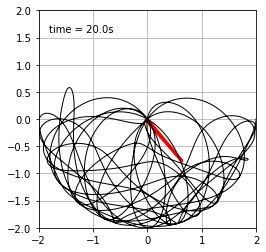

In [4]:
data = rk4(f, [np.pi/2, np.pi/2, 0, 0], 0.001, 0, 20)
fact = 20

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()
plt.gca().set_aspect('equal', adjustable='box')

line, = ax.plot([], [], 'r-', lw=3)
extremity, = ax.plot([], [], 'black', lw=1)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
x1 = l*np.sin(data[1][:,0])
y1 = -l*np.cos(data[1][:,0])
x2 = x1 + l*np.sin(data[1][:,1])
y2 = y1 - l*np.cos(data[1][:,1])

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    thisx = [0, x1[i*fact], x2[i*fact]]
    thisy = [0, y1[i*fact], y2[i*fact]]
    line.set_data(thisx, thisy)
    extremity.set_data(x2[:i*fact+1], y2[:i*fact+1])
    time_text.set_text(time_template % (data[0][i*fact]))
    return extremity, line, time_text

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=int(len(data[1])/fact), interval=20, blit=True)
#anim.save("double_pendulum.mp4", fps=fact*5/2)
HTML(anim.to_html5_video())

Observed order of convergence: p = 3.835


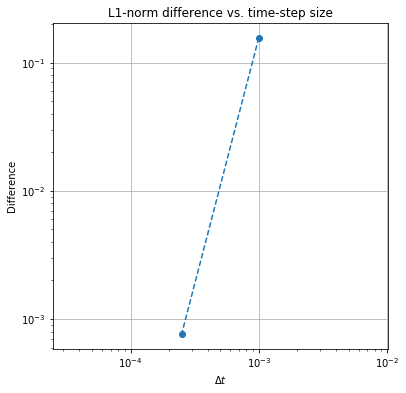

In [5]:
r = 0.25
h = 0.001
dt_values = [h, r*h, r**2*h]
u_values = [rk4(f, [np.pi/2, np.pi/2, 0, 0], dt, 0, 20)[1] for dt in dt_values]

def l1_diff(u_coarse, u_fine, dt):
    N_coarse = len(u_coarse)
    N_fine = len(u_fine)
    ratio = int(np.ceil(N_fine / N_coarse))
    return dt * np.sum(np.abs(u_coarse - u_fine[::ratio]))

diff_values = [l1_diff(u_values[i], u_values[-1], dt_values[i]) for i in range(len(dt_values)-1)]
f2_f1 = l1_diff(u_values[0], u_values[1], dt_values[1])
f3_f2 = l1_diff(u_values[1], u_values[2], dt_values[2])
p = np.log(f3_f2 / f2_f1) / np.log(r)
print('Observed order of convergence: p = {:.3f}'.format(p))
    
# Plot the difference versus the time-step size.
plt.figure(figsize=(6.0, 6.0))
plt.title('L1-norm difference vs. time-step size')  # set the title
plt.xlabel('$\Delta t$')  # set the x-axis label
plt.ylabel('Difference')  # set the y-axis label
plt.grid()
plt.loglog(dt_values[:-1], diff_values,
              color='C0', linestyle='--', marker='o')  # log-log plot
plt.axis('equal');  # make axes scale equally

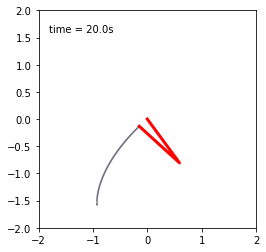

In [6]:
data = rk4(f, [np.pi/2, np.pi/2, 0, 0], 0.001, 0, 20)
fact = 50

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()
Ax = [ax]
plt.gca().set_aspect('equal', adjustable='box')

line, = ax.plot([], [], 'r-', lw=3)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
x1 = l*np.sin(data[1][:,0])
y1 = -l*np.cos(data[1][:,0])
x2 = x1 + l*np.sin(data[1][:,1])
y2 = y1 - l*np.cos(data[1][:,1])
dy2dx2 = np.diff(y2)/np.diff(x2)

p_extremity = np.array([x2, y2]).T.reshape(-1, 1, 2)
segments = np.concatenate([p_extremity[:-1], p_extremity[1:]], axis=1)
# Create a continuous norm to map from data points to colors

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    fig.delaxes(Ax[0])
    Ax[0] = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
    plt.gca().set_aspect('equal', adjustable='box')
    thisx = [0, x1[i*fact], x2[i*fact]]
    thisy = [0, y1[i*fact], y2[i*fact]]
    line, = Ax[0].plot(thisx, thisy, 'r-', lw=3)
    if i < 5:
        norm = plt.Normalize(dy2dx2.min(), dy2dx2.max())
        lc = LineCollection(segments[:i*fact], cmap='bone', norm=norm)
        lc.set_array(dy2dx2)
    else:
        temp_dy2dx2 = dy2dx2[(i-5)*fact:i*fact]
        norm = plt.Normalize(temp_dy2dx2.min(), temp_dy2dx2.max())
        lc = LineCollection(segments[(i-5)*fact:i*fact], cmap='bone', norm=norm)
        lc.set_array(temp_dy2dx2)
    lc.set_linewidth(1.5)
    Ax[0].add_collection(lc)
    time_text = Ax[0].text(0.05, 0.9, time_template % (data[0][i*fact]), transform=Ax[0].transAxes)
    return line, time_text

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=int(len(data[1])/fact), interval=fact, blit=True)
#anim.save("double_pendulum.mp4", fps=fact*5/2)
HTML(anim.to_html5_video())